In [ ]:
import os
import json
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split

In [3]:
from tqdm import tqdm
from pathlib import Path
import pandas as pd

def data(dataset_path):
    images = []
    labels = []
    dataset_path = Path(dataset_path)
    
    for subfolder in tqdm(dataset_path.iterdir(), desc="Processing Subfolders"):
        if subfolder.is_dir():
            for image_file in subfolder.iterdir():
                if image_file.is_file():
                    images.append(str(image_file))
                    labels.append(subfolder.name)
    
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [4]:
color_path = '/Users/amanvaibhavjha/Desktop/Sem6/Adv. ML LAB/Tanu/Plant_leave_diseases_dataset_with_augmentation'
train_color = data(color_path)
print(train_color.shape)
train_color.label.value_counts().to_frame()
num_classes = train_color['label'].unique()
print(f"Number of classes: {num_classes}")

Processing Subfolders: 39it [00:00, 66.95it/s]

(61486, 2)
Number of classes: ['Strawberry___healthy' 'Grape___Black_rot' 'Potato___Early_blight'
 'Blueberry___healthy' 'Cherry___Powdery_mildew' 'Tomato___Target_Spot'
 'Peach___healthy' 'Potato___Late_blight' 'Tomato___Late_blight'
 'Tomato___Tomato_mosaic_virus' 'Pepper,_bell___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Tomato___Leaf_Mold'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Apple___Cedar_apple_rust'
 'Tomato___Bacterial_spot' 'Grape___healthy'
 'Corn___Cercospora_leaf_spot Gray_leaf_spot' 'Tomato___Early_blight'
 'Grape___Esca_(Black_Measles)' 'Raspberry___healthy' 'Tomato___healthy'
 'Corn___Northern_Leaf_Blight' 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
 'Cherry___healthy' 'Apple___Apple_scab'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Corn___Common_rust'
 'Background_without_leaves' 'Peach___Bacterial_spot'
 'Pepper,_bell___Bacterial_spot' 'Tomato___Septoria_leaf_spot'
 'Corn___healthy' 'Squash___Powdery_mildew' 'Apple___Black_rot'
 'Apple___healthy'

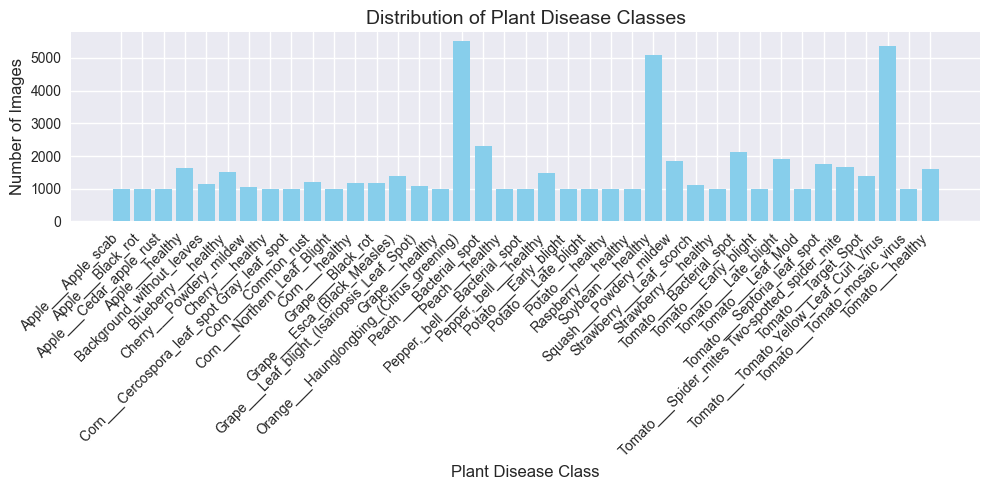

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame creation (uncomment and adjust if you already have train_color)
# train_color = pd.read_csv('your_dataset.csv')  # or however you load your data

# If train_color is already defined and has a column 'label', then count the occurrences:
label_counts = train_color['label'].value_counts().sort_index()

# Plotting the bar graph
plt.figure(figsize=(10, 5))
plt.bar(label_counts.index, label_counts.values, color='skyblue')

# Customize the plot
plt.xlabel('Plant Disease Class', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.title('Distribution of Plant Disease Classes', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Display the plot
plt.show()


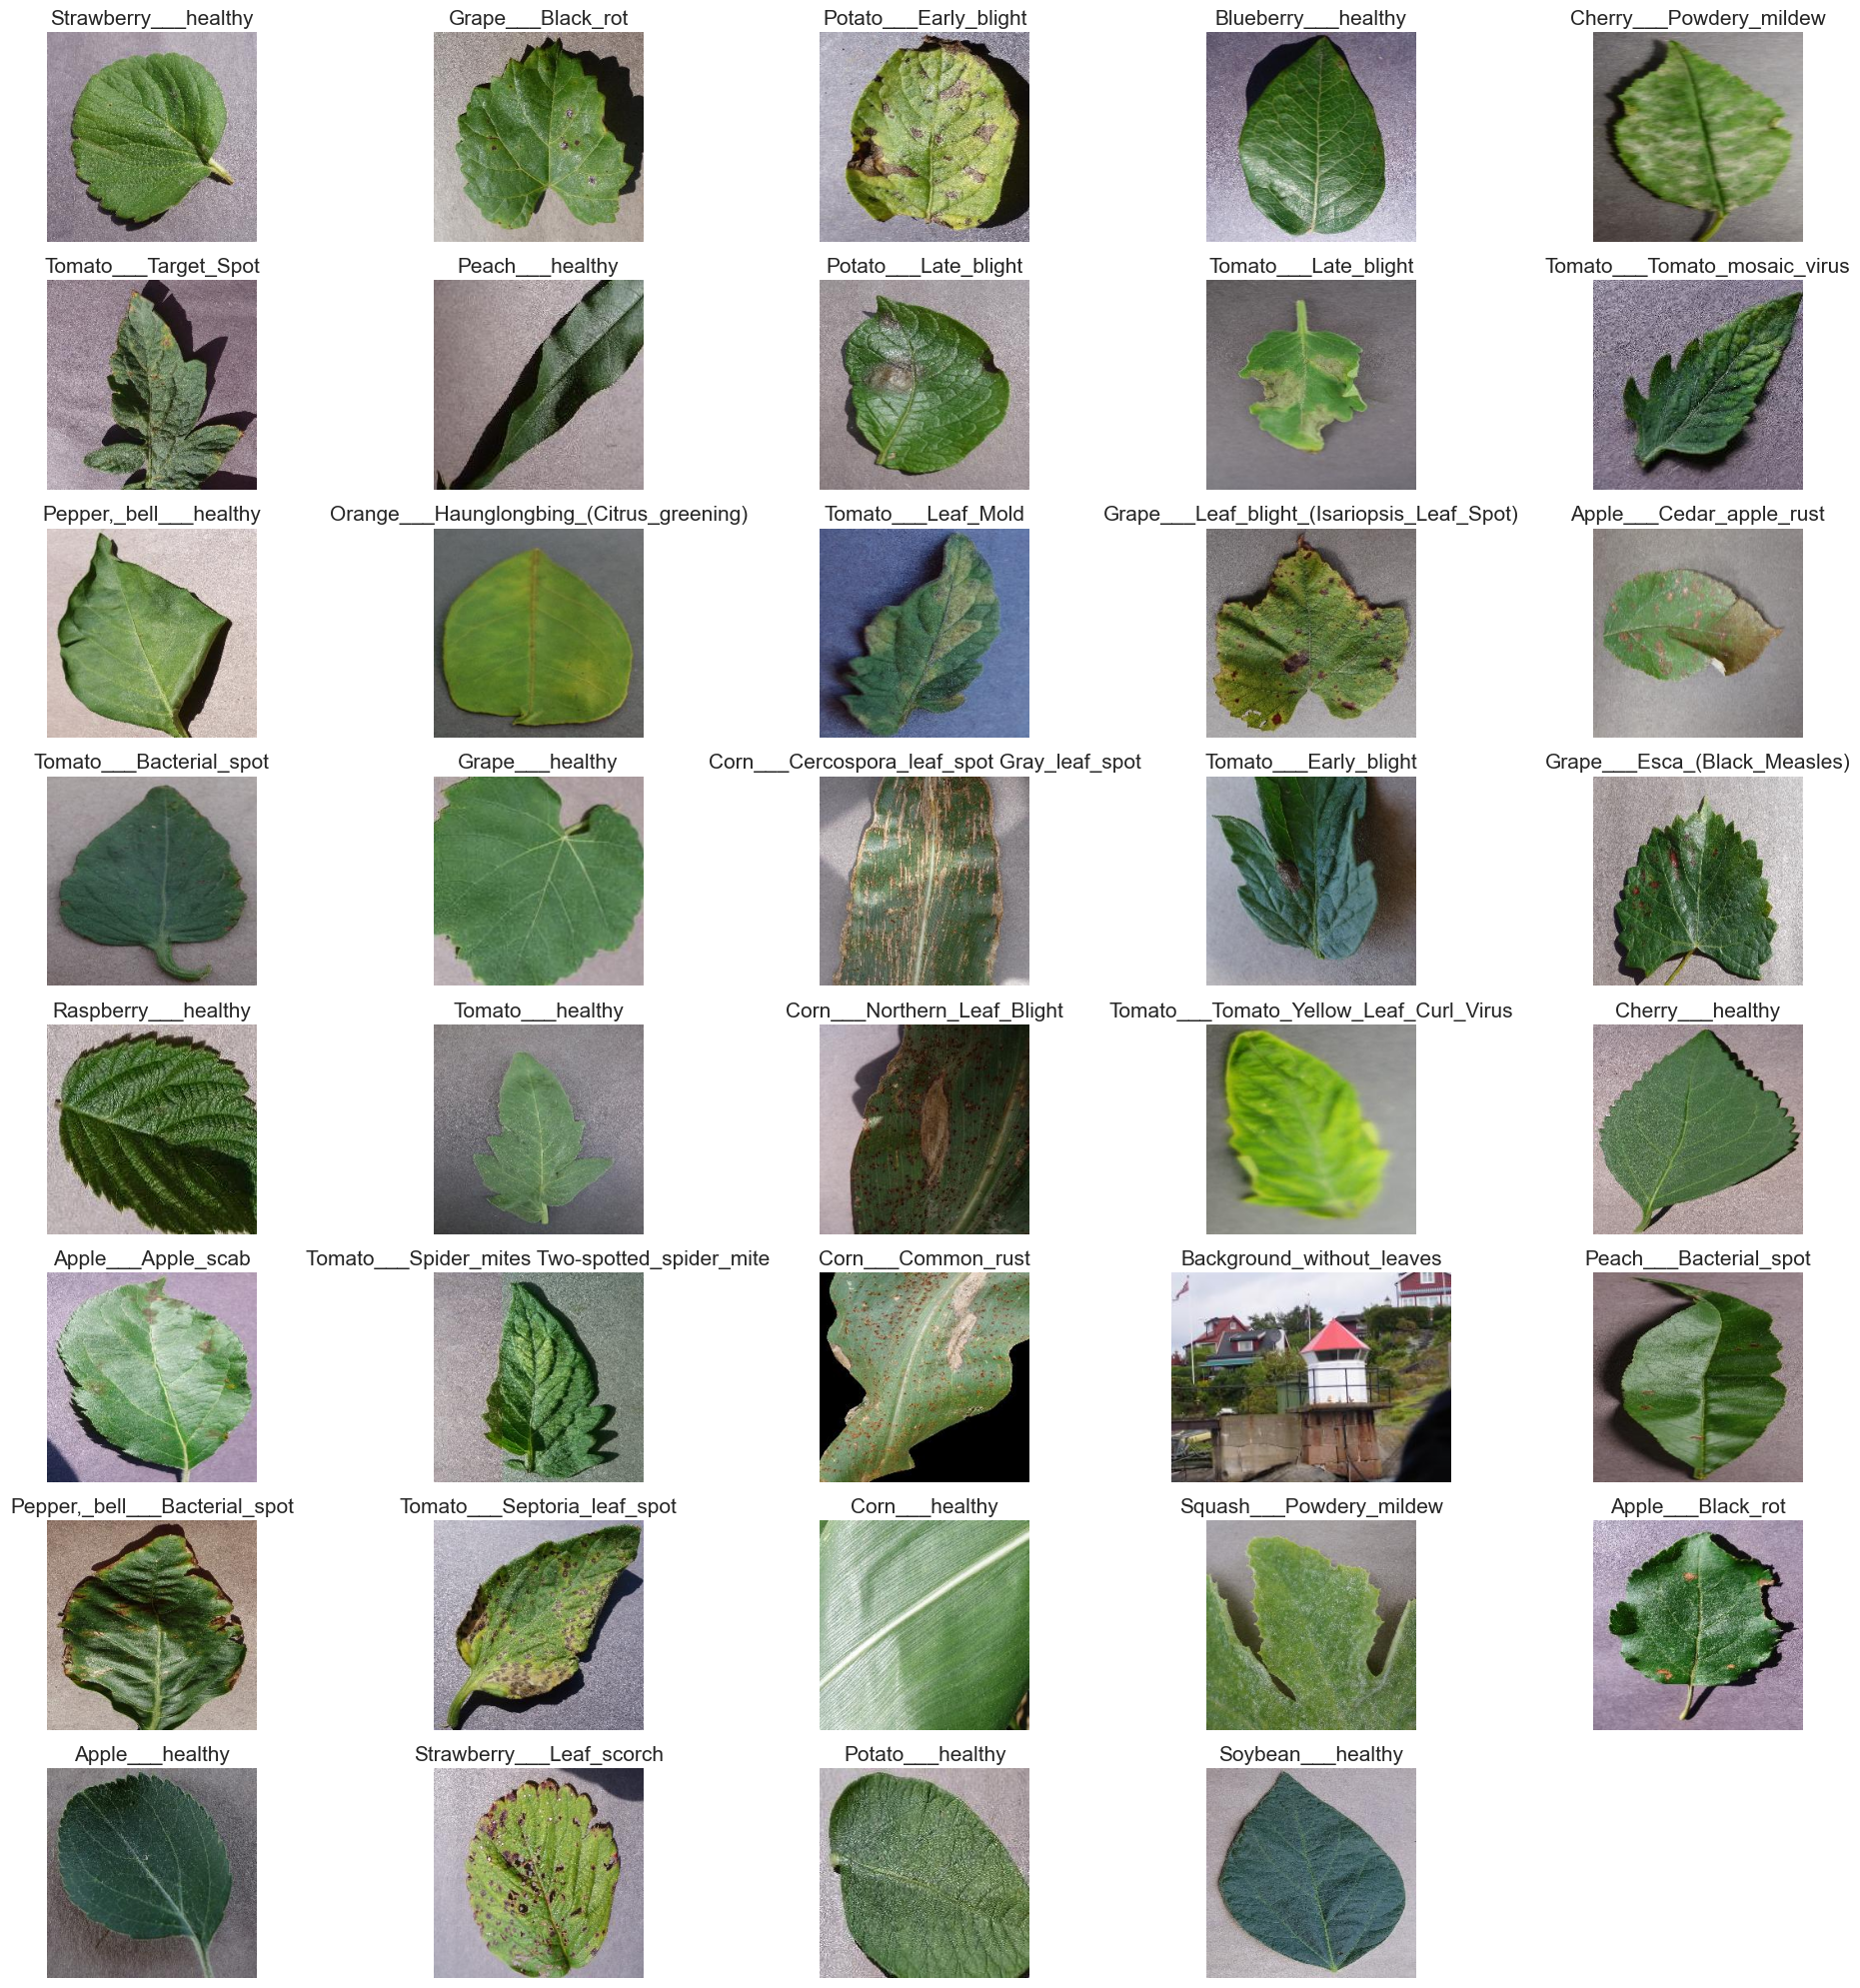

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# List all immediate subdirectories (class names)
class_names = [dirname for dirname in os.listdir(color_path) if os.path.isdir(os.path.join(color_path, dirname))]

plt.style.use('seaborn-v0_8')
plt.figure(figsize=(20, 20))

# Loop through each class
for idx, class_name in enumerate(class_names):
    # Get the path to the class directory
    class_dir = os.path.join(color_path, class_name)
    
    # List all images in the class directory
    image_files = [file for file in os.listdir(class_dir) if file.endswith(('.png', '.jpg', 'JPG', '.jpeg'))]
    
    if not image_files:
        continue  # Skip if no images are found in the class folder
    
    # Randomly select an image
    random_image = np.random.choice(image_files)
    
    # Load the image
    img_path = os.path.join(class_dir, random_image)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Plot the image
    plt.subplot(len(class_names) // 5 + 1, 5, idx + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(class_name, fontsize=15)

plt.tight_layout()
plt.show()

In [8]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_color['image'], train_color['label'], test_size=0.2, random_state=42,shuffle=True,stratify=train_color['label'])
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
df_train = pd.DataFrame({'image': X_train, 'label': y_train})
df_test = pd.DataFrame({'image': X_test, 'label': y_test})
df_val = pd.DataFrame({'image': X_val, 'label': y_val})

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
image_size = (224, 224)
batch_size = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.15,
    fill_mode='nearest'
)

# Validation and test data generator (only rescaling)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical'
)

Found 49188 validated image filenames belonging to 39 classes.
Found 6149 validated image filenames belonging to 39 classes.
Found 6149 validated image filenames belonging to 39 classes.


In [10]:
base_model = VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Freeze the base model if you want to perform transfer learning without fine-tuning the convolutional layers.
base_model.trainable = False

# Build the model by adding custom layers on top of the base model
model_vgg = Sequential([
    base_model,
    Flatten(),
    Dense(39, activation="softmax")  # 39 classes in the dataset
])

# %%
# Compile the model
model_vgg.compile(
    optimizer="Adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Display the model summary
model_vgg.summary()

2025-02-10 21:49:21.246412: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-02-10 21:49:21.246436: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2025-02-10 21:49:21.246445: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2025-02-10 21:49:21.246626: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-10 21:49:21.246641: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 39)             │       978,471 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,693,159 (59.86 MB)

 Trainable params: 978,471 (3.73 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Training parameters
epochs = 5
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

# Callbacks
callbacks = [
    ModelCheckpoint(
        'best_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

# Training
history = model_vgg.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# Evaluate on test set
test_loss, test_accuracy = model_vgg.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')


Epoch 1/5
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.7402 - loss: 0.9375

/Users/amanvaibhavjha/Desktop/Sem6/Adv. ML LAB/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1537/1537 ━━━━━━━━━━━━━━━━━━━━ 331s 215ms/step - accuracy: 0.7402 - loss: 0.9374 - val_accuracy: 0.8592 - val_loss: 0.5860 - learning_rate: 0.0010
Epoch 2/5
   1/1537 ━━━━━━━━━━━━━━━━━━━━ 4:50 189ms/step - accuracy: 0.8438 - loss: 0.8445

/Users/amanvaibhavjha/Desktop/Sem6/Adv. ML LAB/.venv/lib/python3.11/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


1537/1537 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - accuracy: 0.8438 - loss: 0.8445 - val_accuracy: 0.8555 - val_loss: 0.5917 - learning_rate: 0.0010
Epoch 3/5
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 330s 215ms/step - accuracy: 0.8294 - loss: 0.6696 - val_accuracy: 0.8763 - val_loss: 0.5824 - learning_rate: 0.0010
Epoch 4/5
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 36s 24ms/step - accuracy: 0.9062 - loss: 0.7645 - val_accuracy: 0.8714 - val_loss: 0.5775 - learning_rate: 0.0010
Epoch 5/5
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 328s 214ms/step - accuracy: 0.8531 - loss: 0.6378 - val_accuracy: 0.9121 - val_loss: 0.3956 - learning_rate: 0.0010
193/193 ━━━━━━━━━━━━━━━━━━━━ 37s 189ms/step - accuracy: 0.9200 - loss: 0.3622
Test accuracy: 0.9162


In [62]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


193/193 ━━━━━━━━━━━━━━━━━━━━ 36s 187ms/step
Confusion Matrix:
[[ 80   4   1 ...   0   0   0]
 [  0 100   0 ...   0   0   0]
 [  0   0 100 ...   0   0   0]
 ...
 [  0   0   0 ... 498   1   0]
 [  0   0   0 ...   0  71   0]
 [  0   0   0 ...   0   0 145]]

Classification Report:
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.96      0.80      0.87       100
                            Apple___Black_rot       0.92      1.00      0.96       100
                     Apple___Cedar_apple_rust       0.97      1.00      0.99       100
                              Apple___healthy       0.91      0.95      0.93       164
                    Background_without_leaves       0.98      0.93      0.95       114
                          Blueberry___healthy       0.94      0.99      0.97       150
                      Cherry___Powdery_mildew       1.00      0.97      0.99       105
                         

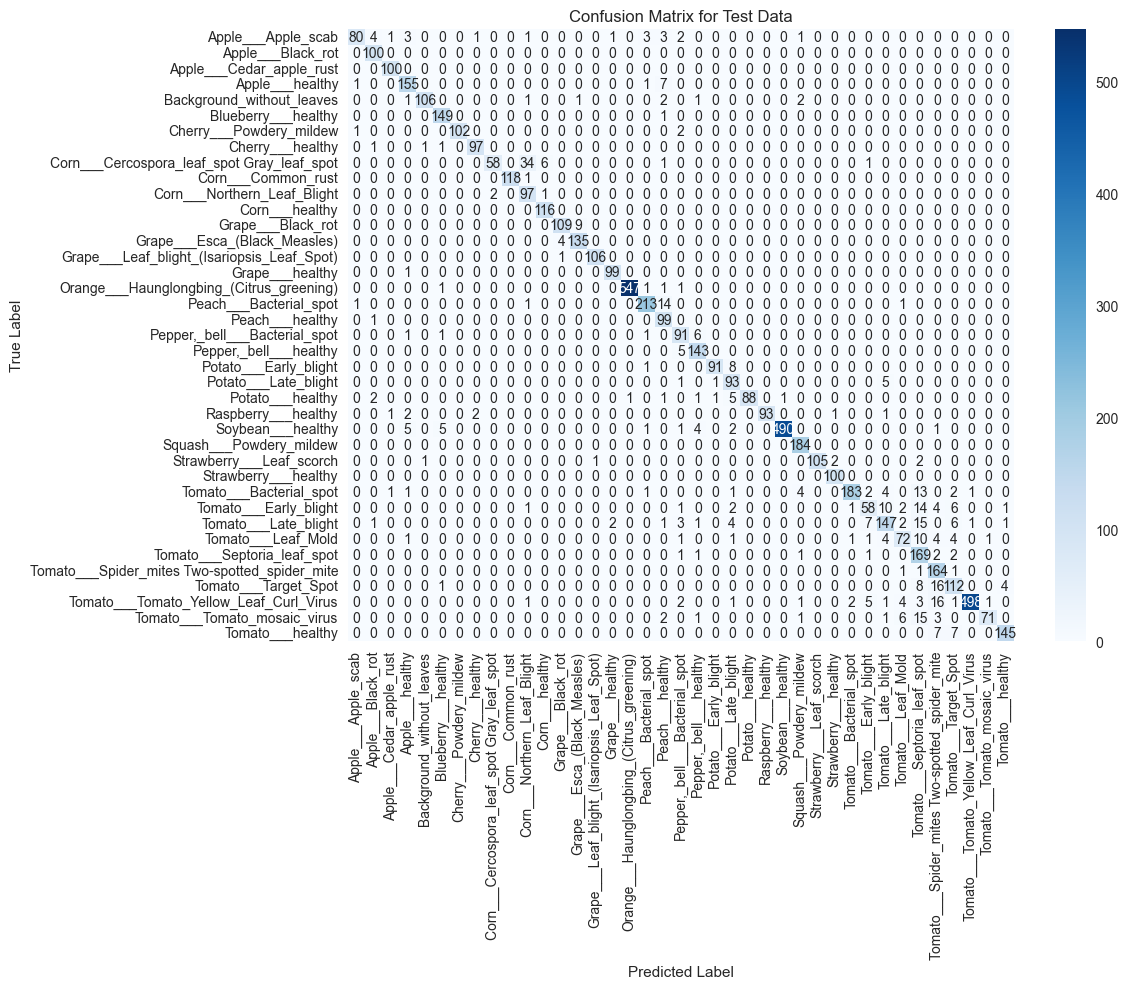

In [63]:
test_steps = test_generator.samples // test_generator.batch_size
if test_generator.samples % test_generator.batch_size != 0:
    test_steps += 1

# Get predictions for the test data
predictions = model_vgg.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes from the test generator
true_classes = test_generator.classes

# If available, get the class labels mapping from the generator
class_labels = list(test_generator.class_indices.keys())

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

# Optionally, print a detailed classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("\nClassification Report:")
print(report)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Data')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
history = model_vgg.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=validation_steps,
    callbacks=callbacks
)

# Evaluate on test set
test_loss, test_accuracy = model_vgg.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')

Epoch 1/5
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 329s 214ms/step - accuracy: 0.8703 - loss: 0.5785 - val_accuracy: 0.9139 - val_loss: 0.3779 - learning_rate: 0.0010
Epoch 2/5
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.9375 - loss: 0.1793 - val_accuracy: 0.9142 - val_loss: 0.3755 - learning_rate: 0.0010
Epoch 3/5
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 329s 214ms/step - accuracy: 0.8763 - loss: 0.5940 - val_accuracy: 0.9284 - val_loss: 0.3529 - learning_rate: 0.0010
Epoch 4/5
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 36s 23ms/step - accuracy: 0.9062 - loss: 0.4434 - val_accuracy: 0.9251 - val_loss: 0.3772 - learning_rate: 0.0010
Epoch 5/5
1537/1537 ━━━━━━━━━━━━━━━━━━━━ 337s 219ms/step - accuracy: 0.8828 - loss: 0.5826 - val_accuracy: 0.9084 - val_loss: 0.5064 - learning_rate: 0.0010
193/193 ━━━━━━━━━━━━━━━━━━━━ 36s 189ms/step - accuracy: 0.9278 - loss: 0.3430
Test accuracy: 0.9242


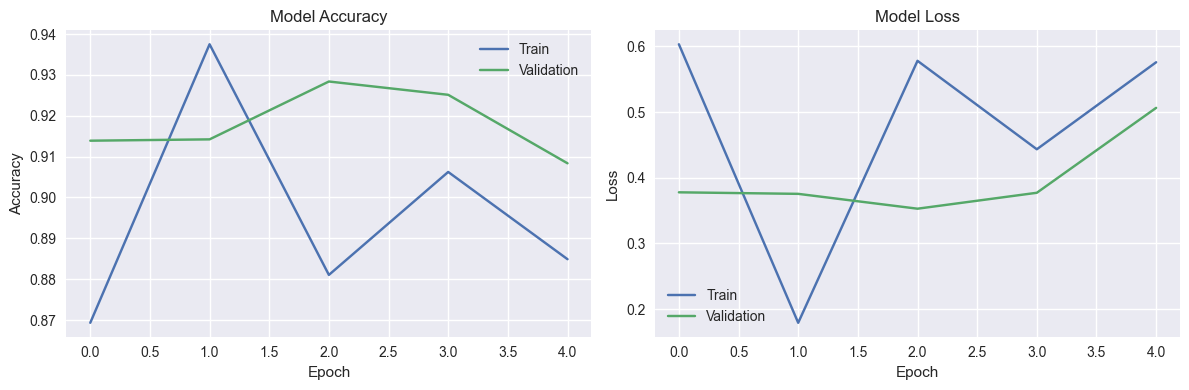

In [17]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(history)

In [19]:
print("Current working directory:", os.getcwd())

# Save model weights with the required file extension (.weights.h5)
model_vgg.save_weights('./vgg_model.weights.h5')

# Save the complete model (architecture + weights) in the current directory.
model_vgg.save('./vgg_model_complete.h5')

print("Model weights and complete model have been saved in the current directory.")

Current working directory: /Users/amanvaibhavjha/Desktop/Sem6/Adv. ML LAB/Tanu
Model weights and complete model have been saved in the current directory.


In [20]:
class_indices = train_generator.class_indices
index_to_class = {v: k for k, v in class_indices.items()}


In [21]:
print("Class indices:", class_indices)

Class indices: {'Apple___Apple_scab': 0, 'Apple___Black_rot': 1, 'Apple___Cedar_apple_rust': 2, 'Apple___healthy': 3, 'Background_without_leaves': 4, 'Blueberry___healthy': 5, 'Cherry___Powdery_mildew': 6, 'Cherry___healthy': 7, 'Corn___Cercospora_leaf_spot Gray_leaf_spot': 8, 'Corn___Common_rust': 9, 'Corn___Northern_Leaf_Blight': 10, 'Corn___healthy': 11, 'Grape___Black_rot': 12, 'Grape___Esca_(Black_Measles)': 13, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14, 'Grape___healthy': 15, 'Orange___Haunglongbing_(Citrus_greening)': 16, 'Peach___Bacterial_spot': 17, 'Peach___healthy': 18, 'Pepper,_bell___Bacterial_spot': 19, 'Pepper,_bell___healthy': 20, 'Potato___Early_blight': 21, 'Potato___Late_blight': 22, 'Potato___healthy': 23, 'Raspberry___healthy': 24, 'Soybean___healthy': 25, 'Squash___Powdery_mildew': 26, 'Strawberry___Leaf_scorch': 27, 'Strawberry___healthy': 28, 'Tomato___Bacterial_spot': 29, 'Tomato___Early_blight': 30, 'Tomato___Late_blight': 31, 'Tomato___Leaf_Mold': 32, 

In [22]:
model = tf.keras.models.load_model('./vgg_model_complete.h5')

In [52]:
image_path = '/Users/amanvaibhavjha/Desktop/Sem6/Adv. ML LAB/Tanu/Plant_leave_diseases_dataset_with_augmentation/Pepper,_bell___Bacterial_spot/image (10).JPG'

In [53]:
img = cv2.imread(image_path)
if img is None:
    raise ValueError("Check the image path. The image was not found.")

# Convert BGR (OpenCV default) to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [54]:
img_resized = cv2.resize(img_rgb, (224, 224))

# Normalize pixel values (assuming the model was trained with images rescaled by 1./255)
img_normalized = img_resized.astype("float32") / 255.0

# Expand dimensions to match the shape the model expects (batch size, height, width, channels)
img_input = np.expand_dims(img_normalized, axis=0)

In [55]:
predictions = model.predict(img_input)

# Get the index of the class with the highest probability
predicted_class_index = np.argmax(predictions, axis=1)[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


In [56]:
predicted_label = index_to_class.get(predicted_class_index, "Unknown")

Predicted class index: 19
Predicted label: Pepper,_bell___Bacterial_spot


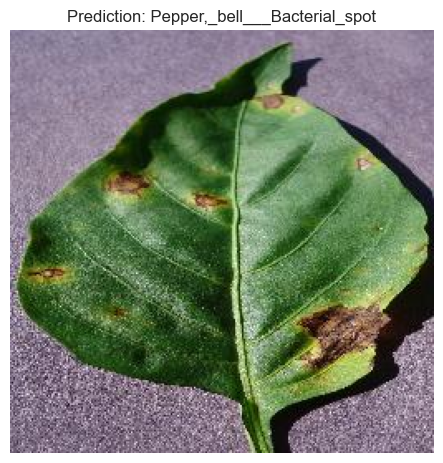

In [57]:
print(f"Predicted class index: {predicted_class_index}")
print(f"Predicted label: {predicted_label}")

# Optionally, display the image with its predicted label
plt.imshow(img_rgb)
plt.title(f"Prediction: {predicted_label}")
plt.axis('off')
plt.show()